# Challenge 2 - NLP

## Libraries

In [1]:
#Default
import os
import re
import warnings
import numpy as np
import pandas as pd

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt


#NLP
## nltk
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
## gensim
import gensim
import gensim.corpora as corpora
from gensim.models.phrases import Phrases
from gensim.models.coherencemodel import CoherenceModel
## wordcloud
from wordcloud import WordCloud, STOPWORDS


#Others
import string
import unidecode

#Configuration
sns.set_style("darkgrid")
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/joseph/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Utils Functions

In [3]:
def createDataset(files):
    """
    Description:
    -------------
    Creating data from a file .txt

    Params:
    -------------
    files: list of the file path that we want to create a dataset

    Return:
    -------------
    DataFrame : dataset creating
    """
    print("Creating dataset ...")
    all_data = []
    for idx, file in enumerate(files):
        reader = open(file, mode='r', encoding='utf-8')
        reader = reader.read()
        data = {
            'idx': idx,
            'content': reader
        }
        all_data.append(data)
    
    df = pd.DataFrame(all_data)
    return df

def checkDataQuality(textList):
    """
    Description:
    -------------
    Check the quality of the dataset.
    
    Params:
    -------------
    textList: List of texts of the dataset.
    
    Return:
    -------------
    Boolean : True if quality if OK.
    """
    print("Checking data quality ...")
    # Checking if each element is a string
    assert all([isinstance(text, str) for text in textList])
    assert all([text != np.nan for text in textList])
    return True

def removeUnwantedChar(textList):
    """
    Description:
    -------------
    Remove all unwanted characters in sentences.
    
    Params:
    -------------
    textList: List of texts of the dataset.
    
    Return:
    -------------
    unw_char: List of texts of the dataset without unwanted characters.
    """
    print("Removing unwanted characters ...")
    unw_char = []
    for word in textList:
        text = re.sub(r'\s+', ' ', word) #remove newline chars
        text = re.sub(r"\'", "", word) #remove single quotes
        text = re.sub(r'https?:\/\/[A-Za-z0-9_.-~\-]*', ' ', word) #remove links
        text = re.sub(r'[(){}<>]', ' ', word) #remove parenthesis, &, >
        text = re.sub(r'&#.*;', ' ', word)
        text = re.sub(r'>', ' ', word)
        text = re.sub(r'â€™', "'", word)
        text = re.sub(r'​', ' ', word)
        text = re.sub(r'\d+', ' ', word)
        # Removing Twitter username, email address and phone number
        text = re.sub(r'@\S+( |\n)', '', word)
        text = re.sub(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+\.[a-zA-Z0-9-_.]+', '', word)
        text = re.sub(r"\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}", '', word)
        # Removing multiple spaces
        text = re.sub(r'\s+', ' ', word)
        unw_char.append(text)
    return unw_char

def removePunctuation(textList):
    """
    Description:
    -------------
    Remove all punctuation in sentences.
    
    Params:
    -------------
    textList: List of texts of the dataset.
    
    Return:
    -------------
    without_punc: List of texts of the dataset without punctuation.
    """
    print("Removing punctuation ...")
    without_punc = []
    
    for text in textList:
        tmp = "".join([i for i in text if i not in string.punctuation])
        tmp = tmp.replace("‘","")
        without_punc.append(tmp.replace("’"," "))
    return without_punc


def removeAccent(textList):
    """
    Description:
    -------------
    Remove all accent in sentences.
    
    Params:
    -------------
    textList: List of texts of the dataset.
    
    Return:
    -------------
    without_accent: List of texts of the dataset without accent.
    """
    print("Removing accents ...")
    without_accent = []
    for text in textList:
        without_accent.append(unidecode.unidecode(text))
    return without_accent

def textToLowerCase(textList):
    """
    Description:
    -------------
    Convert text to lowercase.
    
    Params:
    -------------
    textList: List of texts of the dataset.
    
    Return:
    -------------
    lowercase: List of texts of the dataset in lowercase.
    """
    print("Text to lowercase ...")
    lowercase = []
    for text in textList:
        lowercase.append(text.lower())
    return lowercase

def textToList(textList):
    """
    Description:
    -------------
    Convert text to list of words.
    
    Params:
    -------------
    textList: List of texts of the dataset.
    
    Return:
    -------------
    word_list: List of texts of the dataset in list of words.
    """
    print("Sentences to list ...")
    word_list = []
    for text in textList:
        word_list.append(text.split())
    return word_list


def useless_words_removing(textList):
    """
    Description:
    -------------
    Remove stopwords from texts.
    
    Params:
    -------------
    textList: List of texts of the dataset.
    
    Return:
    -------------
    with_useful_words: List of texts of the dataset without stopwords.
    """
    print("Removing useless words ...")
    stopwords_ = stopwords.words('english')
    with_useful_words = []
    for text in textList:
        with_useful_words.append([word for word in text if not word in stopwords_])
    return with_useful_words

def n_gram_creation(textList):
    """
    Description:
    -------------
    Find 2-gram and 3-gram in a sentence.
    
    Params:
    -------------
    textList: List of texts of the dataset.
    
    Return:
    -------------
    with_n_gram: List of texts of the dataset with 2-gram and 3-gram.
    """
    print("Creating bi-grams and tri-grams ...")
    bigram = Phrases(textList, min_count=40, threshold=10)
    trigram = Phrases(bigram[textList], min_count=40, threshold=10)
    with_n_gram = []
    for text in textList:
        with_n_gram.append(trigram[bigram[text]])
    return with_n_gram

def lemmatization(textList):
    """
    Description:
    -------------
    Lemmatize words.
    
    Params:
    -------------
    textList: List of texts of the dataset.
    
    Return:
    -------------
    lemmatized: List of texts of the dataset with lemmatized words.
    """
    print("Lemmatize words ...")
    lemmatizer = WordNetLemmatizer()
    lemmatized = []
    for text in textList:
        sentence = []
        for word in text:
            sentence.append(lemmatizer.lemmatize(word))
        lemmatized.append(sentence)
    return lemmatized

def tagging(textList):
    """
    Description:
    -------------
    Identify the role of words in a sentence.
    
    Params:
    -------------
    textList: List of texts of the dataset.
    
    Return:
    -------------
    tagged: List of texts of the dataset with words roles.
    """
    print("Tagging ...")
    tagged = []
    for text in textList:
        tagged.append(pos_tag(text))
    return tagged


def for_lda(textList):
    """
    Description:
    -------------
    Create dictionnary and corpus for LDA
    
    Params:
    -------------
    textList: List of texts of the dataset.
    
    Return:
    -------------
    tokens: Dictionnary that links words and their ID.
    corpus: mapping of (word_id, word_frequency)
    """
    print("Preparation for LDA ...")
    ldaed = []
    tokens = corpora.Dictionary(textList)
    texts = textList
    corpus = [tokens.doc2bow(text) for text in texts]
    return tokens, corpus


## Load Dataset

In [4]:
data_dir = os.path.join('data')

In [5]:
#Get files from article
files = []
for file_name in os.listdir(data_dir):
    if file_name.endswith('.txt'):
        files.append(os.path.join(data_dir, file_name))

## Create Dataset

In [6]:
df_ch2 = createDataset(files)

Creating dataset ...


In [7]:
df_ch2.head()

,idx,content
0,0,This is when the arthritis starts. A cheese t...
1,1,"Just like the other animals on this list, the..."
2,2,No better way to spend your days off than rese...
3,3,"In my garden, I grow a lot of medicinal plants..."
4,4,I was hiking through the canyon and found this...


## Data Analyse

In [8]:
df_ch2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   idx      145 non-null    int64 
 1   content  145 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [9]:
# Check missing values
df_ch2.isnull().sum()

idx        0
content    0
dtype: int64

## Data Preprocessing

In [10]:
df_st = df_ch2.copy()

In [11]:
topic_data = df_st.content.to_list()

In [12]:
topic_data

[' This is when the arthritis starts. A cheese that will bring you headaches, joint pain, and fatigue, too much is overwhelming.\n\nMARJORRO\n\nWe’re not sure if this is a wonderful cheese or a bad one. It’s a great cheese to have on your board, but you’ll likely feel like you need to use a hand mixer to get it out. Either way, it’s definitely a cheese with a very long life in the business, but one that probably isn’t good for you that way. Noises, smells, and visions are just what you get.\n\nGREETINGS AFRICA\n\nWhether you are looking for a fun cheese to have with your food, or you are simply curious about this type of cheese, this one is surely intriguing. La Eterna \n\nMore like this:. It’s made from the same substance that land animals utilize to live, namely grass. The natural substance is called it’s strong smell which will strong you up. The color is a bright green, with a lovely leafy smell. It’s a great cheese to have with a glass of wine.\n\nSALTY WATER\n\nIf you’re a big fa

In [13]:
def preprocessing(textList):
    if checkDataQuality(textList) is True:
        print("Starting preprocessing...")
        ## Filtering
        prepro = removeUnwantedChar(textList)
        ## Unify
        prepro = removePunctuation(prepro)
        prepro = removeAccent(prepro)
        prepro = textToLowerCase(prepro)
        ## Converting
        prepro = textToList(prepro)
        ## Remove useless words
        prepro = useless_words_removing(prepro)
        prepro = n_gram_creation(prepro)
        prepro = lemmatization(prepro)

        print("End preprocessing...")

    return prepro

In [14]:
# Check quality
checkDataQuality(topic_data)

Checking data quality ...


True

In [15]:
topic_prepro = preprocessing(topic_data)

Checking data quality ...
Starting preprocessing...
Removing unwanted characters ...
Removing punctuation ...
Removing accents ...
Text to lowercase ...
Sentences to list ...
Removing useless words ...
Creating bi-grams and tri-grams ...
Lemmatize words ...
End preprocessing...


In [16]:
stop_words = stopwords.words('english')

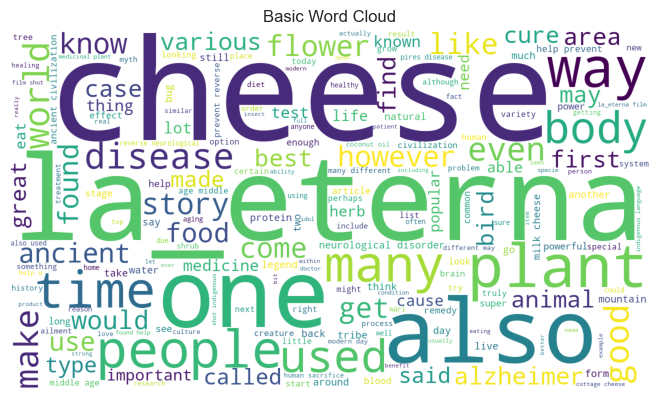

In [17]:
wordcloud_texts = [y for x in topic_prepro for y in x]
text_describe = pd.Series(wordcloud_texts)
wordcloud_texts = ' '.join(wordcloud_texts)
wordcloud = WordCloud(width=1280, height=720, background_color='white', stopwords=stop_words).generate(wordcloud_texts)
plt.imshow(wordcloud)
plt.title("Basic Word Cloud")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()